In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate

plt.style.use('ggplot')


In [2]:
wiki_profiles_df = pd.read_csv('data/wiki_profile_cleaned.csv')

### Create a summary table of the data

In [3]:
group_field_avg = wiki_profiles_df.groupby('nobel_field').mean(['doctorate', 'len_page', 'female', 'male'])
group_field_avg = group_field_avg.reset_index()
group_field_avg = group_field_avg[['female', 'doctorate']]
group_field_sum = wiki_profiles_df.groupby('nobel_field').sum()
group_field_sum = group_field_sum.reset_index()
group_field_sum = group_field_sum[['nobel_field','count']]

In [4]:
#Data Description Table
data_desc = pd.concat([group_field_sum, group_field_avg], axis=1).sort_values('count')
print(tabulate(data_desc, floatfmt=".3f", headers=['Field', 'N', 'Female (proportion)', 'Ph.D (proportion)'], tablefmt="github"))

|    | Field                  |     N |   Female (proportion) |   Ph.D (proportion) |
|----|------------------------|-------|-----------------------|---------------------|
|  1 | Data Science           |    63 |                 0.365 |               0.302 |
|  0 | Chemistry              |  1659 |                 0.234 |               0.429 |
|  2 | Economics              |  2576 |                 0.145 |               0.395 |
|  3 | Physics                |  2837 |                 0.159 |               0.417 |
|  4 | Physiology or Medicine | 10647 |                 0.232 |               0.139 |


### Visualize proportion of women in each field

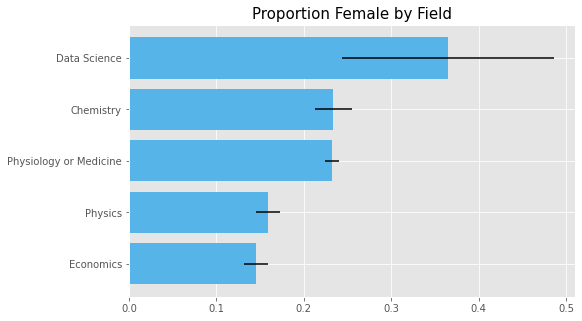

In [5]:
gender_se_dct = {}

nobel = list(data_desc['nobel_field'])

for field in nobel:
    gender_byfield = wiki_profiles_df['female'][wiki_profiles_df['nobel_field']==field]
    
    gender_se = ((gender_byfield.mean()*(1-gender_byfield.mean()))/len(gender_byfield))**.5
    gender_se_dct[field] = gender_se

    
gender_se = pd.DataFrame(list(gender_se_dct.items()), columns = ['nobel_field', 'gender_se'])
data_desc = data_desc[['nobel_field', 'female']]
prop_gender_bycat = pd.merge(gender_se, data_desc, how='inner', on='nobel_field')
prop_gender_bycat = prop_gender_bycat.sort_values('female', ascending=True)

x = prop_gender_bycat['nobel_field']
y = prop_gender_bycat['female']
gender_se_double = [x*2 for x in prop_gender_bycat['gender_se']]

fig, ax = plt.subplots(figsize=(8,5))
#could calculate variance and add error bars

ax.barh(x, y, xerr=gender_se_double, color="#56B4E9")

ax.set_title('Proportion Female by Field', size = 15)

fig.savefig('images/PropWomenbyfield.png', bbox_inches = "tight")

### Visualize the difference in the proportion of women in a field between 20th century and 21st century 
(for categories where this can be differenciated) 

In [6]:
category_list = wiki_profiles_df.groupby('category').count()
category_list = category_list.reset_index()
category_list = list(category_list['category'])

category_forprinting = {}
for category in category_list:
    category_fmt = category.replace("-", " ")
    category_fmt = category_fmt.replace("_", " ")
    category_fmt = ' '.join([x.capitalize() for x in category_fmt.split(' ')])
    
    category_forprinting[category] = category_fmt
    
category_forprinting

{'20th-century_biologists': '20th Century Biologists',
 '20th-century_chemists': '20th Century Chemists',
 '20th-century_economists': '20th Century Economists',
 '20th-century_physicians': '20th Century Physicians',
 '20th-century_physicists': '20th Century Physicists',
 '21st-century_biologists': '21st Century Biologists',
 '21st-century_chemists': '21st Century Chemists',
 '21st-century_economists': '21st Century Economists',
 '21st-century_physicians': '21st Century Physicians',
 '21st-century_physicists': '21st Century Physicists',
 'Data_scientists': 'Data Scientists',
 'Microbiologists': 'Microbiologists'}

In [7]:
gender_se_dct = {}
for category in category_list:
    
    gender_bycategory = wiki_profiles_df['female'][wiki_profiles_df['category']==category]
    gender_se = ((gender_bycategory.mean()*(1-gender_bycategory.mean()))/len(gender_bycategory))**.5
    gender_se_dct[category] = gender_se

    
gender_se = pd.DataFrame(list(gender_se_dct.items()), columns = ['category', 'gender_se'])

group_category = wiki_profiles_df.groupby('category')
group_category = group_category.mean().reset_index()
group_category = group_category[['category','female']]
prop_gender_bycat = pd.merge(gender_se, group_category, how='inner', on='category')
prop_gender_bycat = prop_gender_bycat[(prop_gender_bycat['category'] != 'Microbiologists') & (prop_gender_bycat['category'] != 'Data_scientists')]



temp_field_column_for_sorting = {}
for x in prop_gender_bycat['category']:
    field_name = x.split("_")
    field_name = field_name[-1]
    temp_field_column_for_sorting[x] = field_name

temp_field_elems = []
for cat in prop_gender_bycat['category']:
    if cat in temp_field_column_for_sorting:
        temp_field_elems.append(temp_field_column_for_sorting[cat])
    else:
        print("why don't i exist?")

prop_gender_bycat['temp_field'] = temp_field_elems

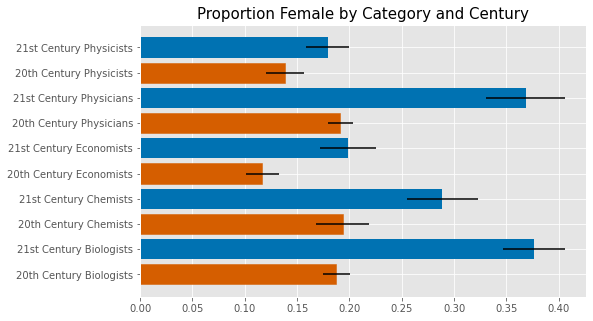

In [8]:
prop_gender_bycat = prop_gender_bycat.sort_values('category')
prop_gender_bycat = prop_gender_bycat.sort_values('temp_field')
prop_gender_bycat.reset_index()
x = prop_gender_bycat['category']

x_printable = [category_forprinting[x_elem] for x_elem in x]

gender_se_double = [x*2 for x in prop_gender_bycat['gender_se']]


y = prop_gender_bycat['female']

fig, ax = plt.subplots(figsize=(8,5))
#could calculate variance and add error bars

bars = ax.barh(x_printable, y, color = "#0072B2", 
                xerr=gender_se_double)
for item in bars[::2]:
    item.set_color("#D55E00")
    
ax.set_title('Proportion Female by Category and Century', size = 15)


fig.savefig('images/PropWomenbyCategory.png', bbox_inches = "tight")

### Bayes Test (proportion female v proportion men by field)

In [9]:
%run src/viz_helper_functions.py

physicians: Percent likelihood that 21st is greater than 20th: 100.00%
physicists: Percent likelihood that 21st is greater than 20th: 99.87%
economists: Percent likelihood that 21st is greater than 20th: 100.00%
chemists: Percent likelihood that 21st is greater than 20th: 100.00%
biologists: Percent likelihood that 21st is greater than 20th: 100.00%


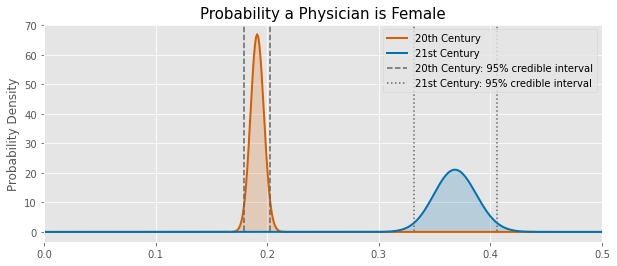

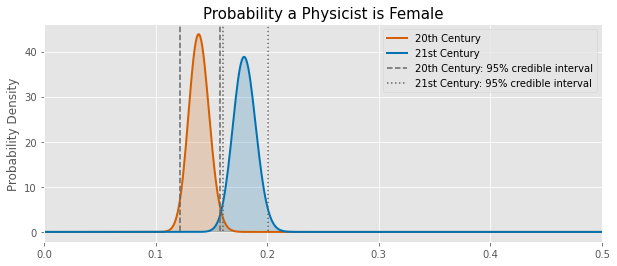

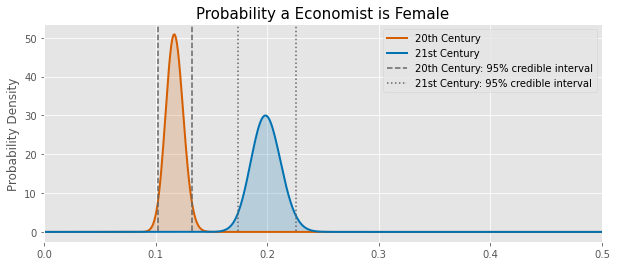

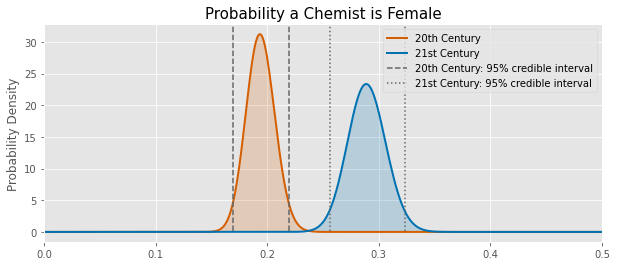

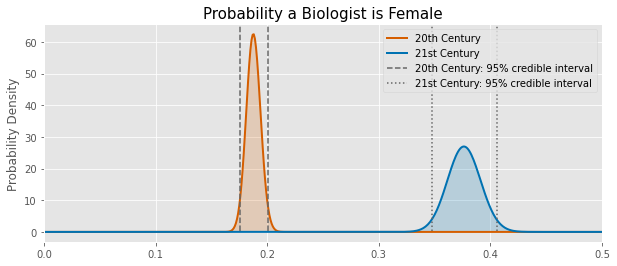

In [10]:
category_list = ['physicians', 'physicists', 'economists', 'chemists', 'biologists']
for category in category_list:
    field_20 = '20th-century_' +  category
    field_21 = '21st-century_' + category
    gender_20 = wiki_profiles_df[wiki_profiles_df['category'] == field_20]
    gender_20 = np.array(gender_20['female'])
    gender_21 = wiki_profiles_df[wiki_profiles_df['category'] == field_21]
    gender_21 = np.array(gender_21['female'])
    
    category_title = category[:-1].capitalize()
    title = f"Probability a {category_title} is Female" 
    dist_20, dist_21, fig = graph_bayes(gender_20, gender_21, '20th Century', '21st Century', title)
    
    save_image = 'images/' + category + '_bayes.png'
    fig.savefig(save_image, bbox_inches = "tight")
    
    
    # What is the probability B is better greater than A?
    #draw points from the distributions
    dist_20_sample = dist_20.rvs(100000)
    dist_21_sample = dist_21.rvs(100000)

    #count the times that dist b value is greater than dist a value
    difference = dist_21_sample-dist_20_sample
    count = sum(difference>0)

    print(f"{category}: Percent likelihood that 21st is greater than 20th: {(count/100000)*100:.2f}%")


### Proportion of male v female with PhD (by field)

In [11]:
# Ttests 

for field in nobel:
    test_f = wiki_profiles_df[(wiki_profiles_df['female']==True) & (wiki_profiles_df['nobel_field']==field)]
    test_f = test_f['doctorate']
    test_m = wiki_profiles_df[(wiki_profiles_df['female']==False) & (wiki_profiles_df['nobel_field']==field)]
    test_m = test_m['doctorate']

    stat, pval = stats.ttest_ind(test_f, test_m, equal_var=False)
    
    difference = test_m.mean()-test_f.mean()
    
    alpha = .01

    if pval > alpha:
        print(f"{field} : diff: {difference:.4f} P-value = {pval:.4f}")

    elif pval < alpha:
        print(f"{field} : diff: {difference:.4f} P-value = {pval:.4f}**")


Data Science : diff: 0.2011 P-value = 0.0780
Chemistry : diff: -0.0756 P-value = 0.0091**
Economics : diff: -0.0100 P-value = 0.7156
Physics : diff: 0.0180 P-value = 0.4769
Physiology or Medicine : diff: -0.0726 P-value = 0.0000**


In [12]:
group_by_cat_gender = wiki_profiles_df.groupby(['nobel_field', 'female'])

#standard errors 
se_fem_dct = {}
se_male_dct = {}

for field in nobel:
    df_male_phd = wiki_profiles_df['doctorate'][(wiki_profiles_df['nobel_field']==field) & (wiki_profiles_df['female']==False)]
    df_female_phd = wiki_profiles_df['doctorate'][(wiki_profiles_df['nobel_field']==field) & (wiki_profiles_df['female']==False)]
    
    women_phd_se = ((df_female_phd.mean()*(1-df_female_phd.mean()))/len(df_female_phd))**.5
    men_phd_se = ((df_male_phd.mean()*(1-df_male_phd.mean()))/len(df_male_phd))**.5
    se_fem_dct[field] = women_phd_se
    se_male_dct[field] = men_phd_se

se_fem_phd = pd.DataFrame(list(se_fem_dct.items()), columns = ['nobel_field', 'fem_phd_se'])
se_male_phd = pd.DataFrame(list(se_male_dct.items()), columns = ['nobel_field', 'male_phd_se'])
phd_se = pd.merge(se_fem_phd, se_male_phd, how='inner', on='nobel_field')

group_by_cat_gender_mean = group_by_cat_gender.mean()
phd_group_cat_gender = group_by_cat_gender_mean['doctorate']
phd_group_cat_gender = phd_group_cat_gender.reset_index()

female_phd = phd_group_cat_gender[phd_group_cat_gender['female'] == True]
male_phd = phd_group_cat_gender[phd_group_cat_gender['female'] == False]

male_phd = male_phd.filter(['nobel_field', 'doctorate'])
male_phd.rename(columns = {'doctorate':'male_phd'}, inplace=True)
female_phd = female_phd.filter(['nobel_field', 'doctorate'])
female_phd.rename(columns = {'doctorate':'female_phd'}, inplace=True)

prop_phd_bycat = pd.merge(male_phd, female_phd, how='inner', on='nobel_field')
prop_phd_bycat = pd.merge(prop_phd_bycat, phd_se, how='inner', on='nobel_field')

prop_phd_bycat.sort_values('male_phd', inplace=True)
prop_phd_bycat
    

,nobel_field,male_phd,female_phd,fem_phd_se,male_phd_se
4,Physiology or Medicine,0.122339,0.194905,0.003624,0.003624
1,Data Science,0.375000,0.173913,0.076547,0.076547
2,Economics,0.393733,0.403743,0.010412,0.010412
0,Chemistry,0.411487,0.487113,0.013803,0.013803
3,Physics,0.420193,0.402222,0.010103,0.010103


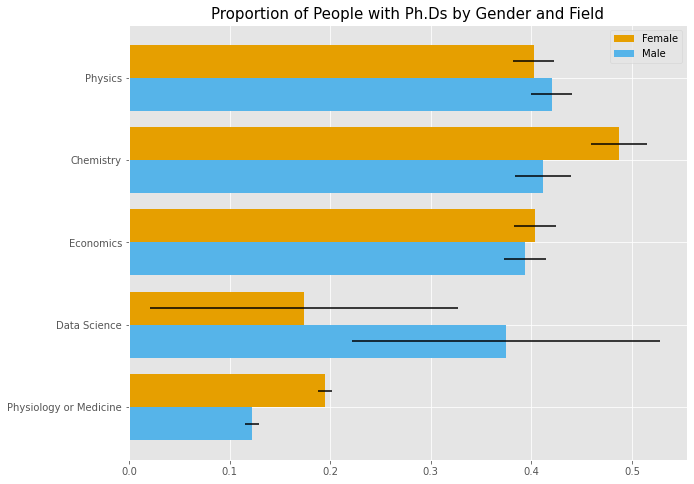

In [13]:
categories = prop_phd_bycat['nobel_field']
y_male = prop_phd_bycat['male_phd']
y_fem = prop_phd_bycat['female_phd']

male_se = prop_phd_bycat['male_phd_se']
fem_se = prop_phd_bycat['fem_phd_se']
male_se_double = [x*2 for x in male_se]
fem_se_double = [x*2 for x in fem_se]

fig, ax = plt.subplots(figsize=(10,8))

N = len(categories) 
ind = np.arange(N) 
width = .4
f = ax.barh(ind+width, y_fem, width, label = 'Female', xerr=fem_se_double, color="#E69F00")
m = ax.barh(ind, y_male, width, label = 'Male', xerr=male_se_double, color="#56B4E9" )

plt.yticks(ind + width / 2, categories, size=10)
plt.legend(loc='best')

ax.set_title('Proportion of People with Ph.Ds by Gender and Field', size=15)

fig.savefig('images/PropPhD_gender_field.png', bbox_inches = "tight")

Physics: Percent likelihood that female is greater than male: 24.17%
Physics: Percent likelihood that male is greater than female: 75.83%
Chemistry: Percent likelihood that female is greater than male: 99.57%
Chemistry: Percent likelihood that male is greater than female: 0.43%
Economics: Percent likelihood that female is greater than male: 64.75%
Economics: Percent likelihood that male is greater than female: 35.25%
Data Science: Percent likelihood that female is greater than male: 5.23%
Data Science: Percent likelihood that male is greater than female: 94.77%
Physiology or Medicine: Percent likelihood that female is greater than male: 100.00%
Physiology or Medicine: Percent likelihood that male is greater than female: 0.00%


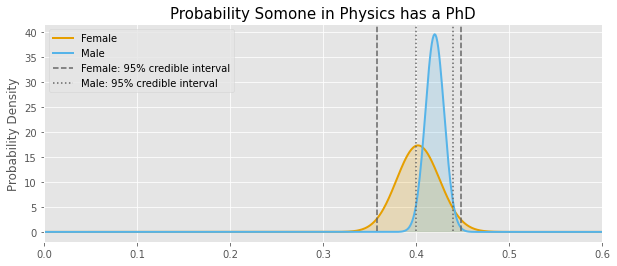

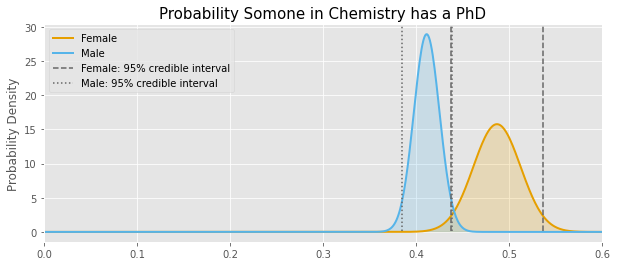

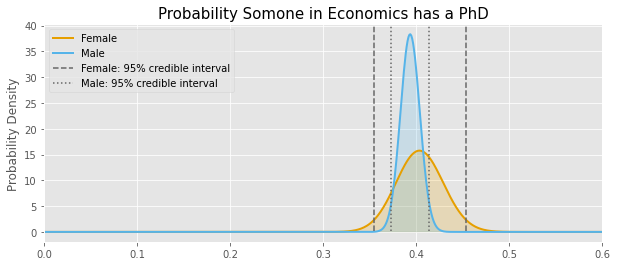

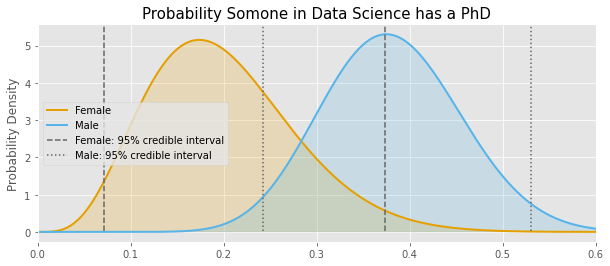

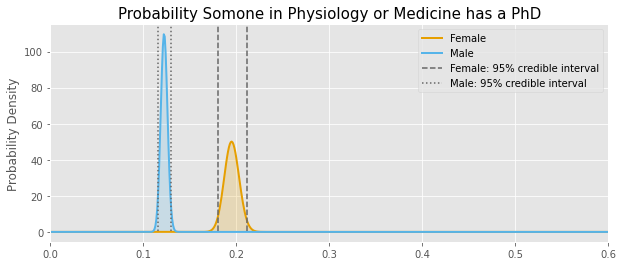

In [14]:
field_list = ['Physics', 'Chemistry', 'Economics', 'Data Science', 'Physiology or Medicine']
for field in field_list:
    phd_female = wiki_profiles_df[(wiki_profiles_df['female'] == True) & (wiki_profiles_df['nobel_field'] == field)]
    phd_female = np.array(phd_female['doctorate'])
    phd_male = wiki_profiles_df[(wiki_profiles_df['female'] == False) & (wiki_profiles_df['nobel_field'] == field)]
    phd_male = np.array(phd_male['doctorate'])
    
    category_title = category[:-1].capitalize()
    title = f"Probability Somone in {field} has a PhD" 
    dist_female, dist_male, fig = graph_bayes(phd_female, phd_male, 'Female', 'Male', title, "#E69F00", "#56B4E9", xmax=.6)
    
    field_png_name = field.replace(" ", "_")
    save_image = 'images/' + field_png_name + '_phd_bayes.png'
    fig.savefig(save_image, bbox_inches = "tight")
    
    
    dist_female_sample = dist_female.rvs(100000)
    dist_male_sample = dist_male.rvs(100000)

    difference = dist_female_sample-dist_male_sample
    count = sum(difference>0)
    
    difference_flipped = dist_male_sample-dist_female_sample
    count_flipped = sum(difference_flipped>0)

    print(f"{field}: Percent likelihood that female is greater than male: {(count/100000)*100:.2f}%")
    print(f"{field}: Percent likelihood that male is greater than female: {(count_flipped/100000)*100:.2f}%")


In [17]:
nobel_data = pd.read_csv('data/nobel.csv')

In [18]:
nobel_data

,field,prizes,laureates,women,youngest,oldest
0,physics,114,216,4,25,96
1,chemistry,112,186,7,35,97
2,medicine,111,222,12,32,87
3,economics,52,86,2,46,90
